In [2]:
# Data Manipulation
import polars as pl
from polars import selectors as cs
from polars import col as c
pl.Config.set_engine_affinity(engine = 'streaming')

# Graphs and Tables Settings
from plotnine import * # gpplot2 in python
pl.Config(tbl_rows = 10, float_precision = 4);
%run "../auxx/theme_ggplot.py"

# Time Series
from fpppy.utils import plot_series
from statsmodels.tsa.seasonal import STL

In [3]:
def import_pivot_data(name):
    return (
    pl.read_excel('../../Data/macro.xlsx', sheet_name = name)
    .unpivot(index = 'date', variable_name = 'country', value_name = name)
    )

In [4]:
cpi = import_pivot_data('cpi')
unemployment = import_pivot_data('unemployment')

In [5]:
cpi

date,country,cpi
date,str,f64
1996-01-01,"""EA""",70.9700
1996-02-01,"""EA""",71.2900
1996-03-01,"""EA""",71.5400
1996-04-01,"""EA""",71.6600
1996-05-01,"""EA""",71.8300
…,…,…
2024-12-01,"""United States""",129.4700
2025-01-01,"""United States""",null
2025-02-01,"""United States""",null


In [7]:
macro = (
    cpi
    .join(unemployment, how = 'left', on = ['country', 'date'])
    .sort(['country', 'date'])
    .with_columns(inflation = c('cpi').pct_change().over('country') * 100 )
    .drop_nulls()
)

macro.write_csv('../../Data/macro2.csv') # for later use

macro = macro.filter(c('country') == 'EA')

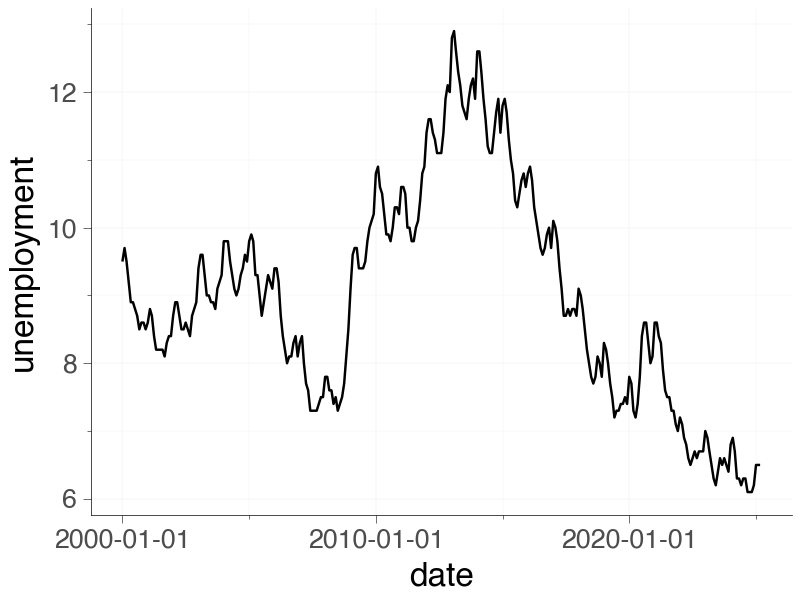

In [8]:
(
    ggplot(data=macro, mapping=aes(x = 'date', y = 'unemployment')) +
    geom_line() +
    #facet_wrap(facets='country') +
    theme(figure_size = (4, 3))
)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/fpppy/utils.py:40: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


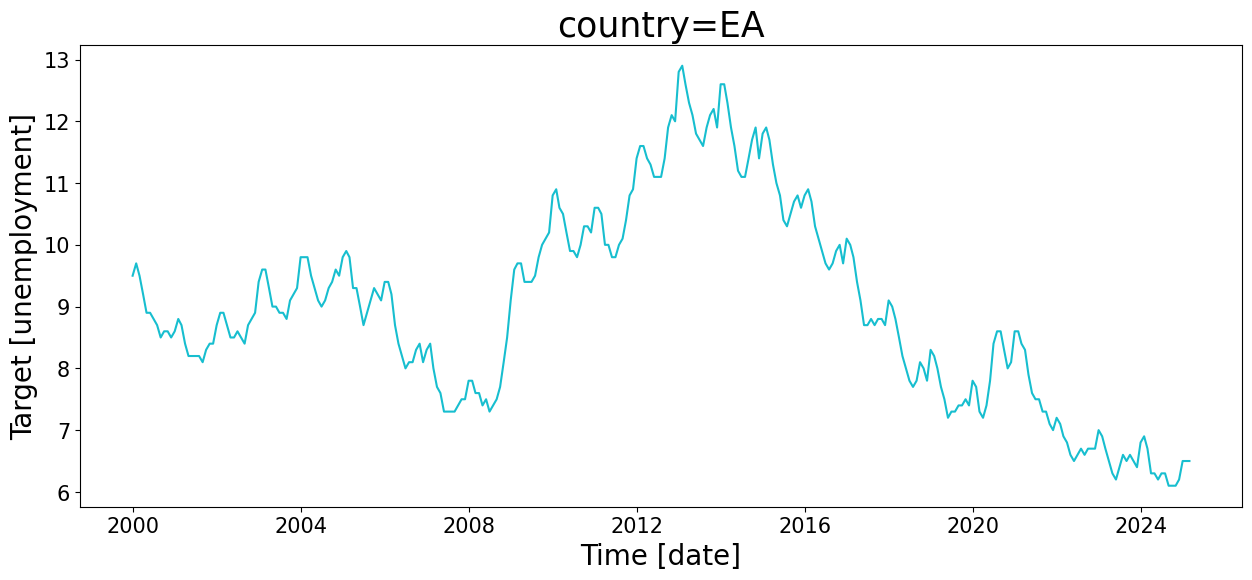

In [9]:
plot_series(
    df = macro,
    id_col = 'country',
    time_col = "date", 
    target_col = "unemployment"
)

In [10]:
stl = STL(macro["unemployment"], period=12).fit()
stl

In [11]:
macro

date,country,cpi,unemployment,inflation
date,str,f64,f64,f64
2000-01-01,"""EA""",75.1300,9.5000,0.0533
2000-02-01,"""EA""",75.3700,9.7000,0.3194
2000-03-01,"""EA""",75.6000,9.5000,0.3052
2000-04-01,"""EA""",75.6700,9.2000,0.0926
2000-05-01,"""EA""",75.7600,8.9000,0.1189
…,…,…,…,…
2024-11-01,"""EA""",126.6200,6.1000,-0.3228
2024-12-01,"""EA""",127.0700,6.2000,0.3554
2025-01-01,"""EA""",126.7200,6.5000,-0.2754


In [12]:
macro2 = (
    macro
    .with_columns(
        Trend = stl.trend,
        Seasonal = stl.seasonal,
        Residuals = stl.resid
    )
    .with_columns(
        unemployment_sa = c('unemployment') - c('Seasonal')
    )
)
macro2

date,country,cpi,unemployment,inflation,Trend,Seasonal,Residuals,unemployment_sa
date,str,f64,f64,f64,f64,f64,f64,f64
2000-01-01,"""EA""",75.1300,9.5000,0.0533,9.3310,0.1236,0.0454,9.3764
2000-02-01,"""EA""",75.3700,9.7000,0.3194,9.2612,0.4043,0.0345,9.2957
2000-03-01,"""EA""",75.6000,9.5000,0.3052,9.1919,0.2968,0.0113,9.2032
2000-04-01,"""EA""",75.6700,9.2000,0.0926,9.1230,0.0700,0.0071,9.1300
2000-05-01,"""EA""",75.7600,8.9000,0.1189,9.0545,-0.1502,-0.0043,9.0502
…,…,…,…,…,…,…,…,…
2024-11-01,"""EA""",126.6200,6.1000,-0.3228,6.2280,-0.0519,-0.0761,6.1519
2024-12-01,"""EA""",127.0700,6.2000,0.3554,6.1986,-0.0078,0.0092,6.2078
2025-01-01,"""EA""",126.7200,6.5000,-0.2754,6.1690,0.3340,-0.0029,6.1660


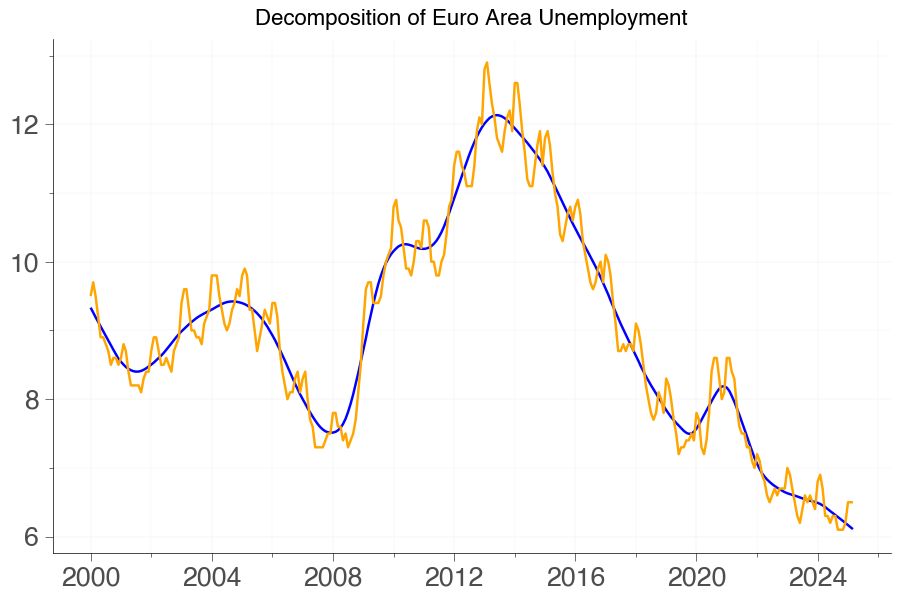

In [16]:
(
    ggplot(data = macro2, mapping=aes(x = 'date') ) +
    geom_line(mapping=aes(y = 'Trend'), color = 'blue') +
    geom_line(mapping=aes(y = 'unemployment'), color = 'orange') +
    labs(y = '', x = '', title = 'Decomposition of Euro Area Unemployment') +
    scale_x_date(breaks='4 years', date_labels='%Y')
)


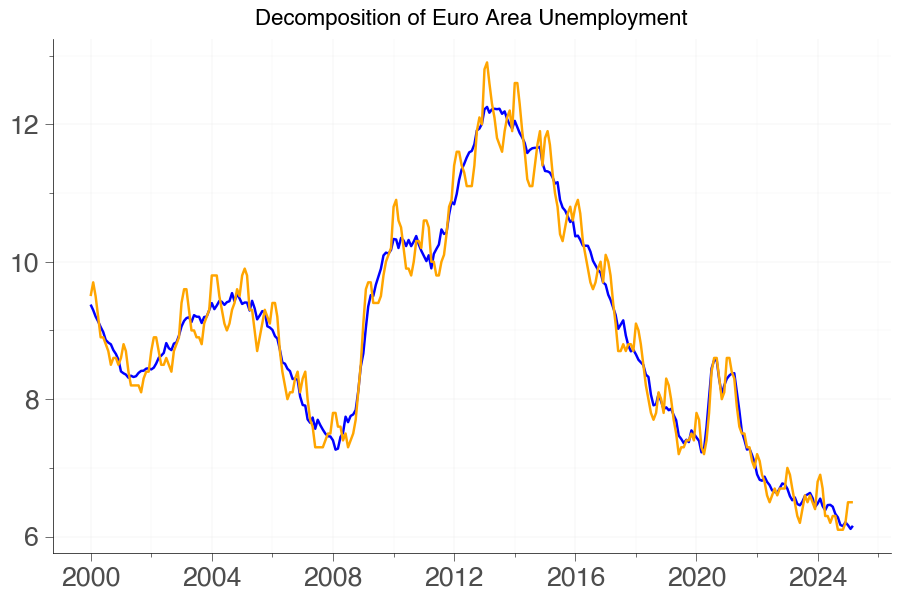

In [14]:
(
    ggplot(data = macro2, mapping=aes(x = 'date') ) +
    geom_line(mapping=aes(y = 'unemployment_sa'), color = 'blue') +
    geom_line(mapping=aes(y = 'unemployment'), color = 'orange') +
    labs(y = '', x = '', title = 'Decomposition of Euro Area Unemployment') +
    scale_x_date(breaks='4 years', date_labels='%Y')
)


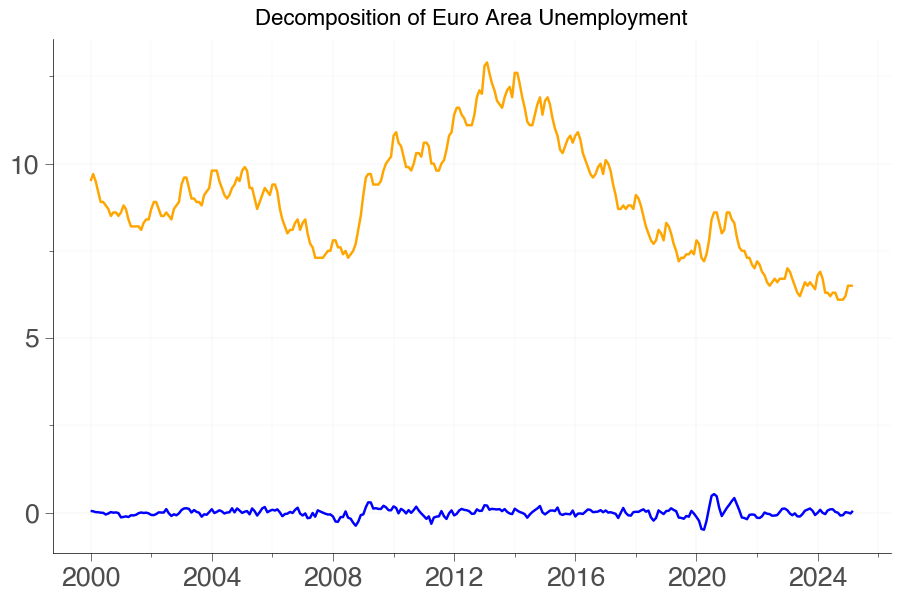

In [17]:
(
    ggplot(data = macro2, mapping=aes(x = 'date') ) +
    geom_line(mapping=aes(y = 'Residuals'), color = 'blue') +
    geom_line(mapping=aes(y = 'unemployment'), color = 'orange') +
    labs(y = '', x = '', title = 'Decomposition of Euro Area Unemployment') +
    scale_x_date(breaks='4 years', date_labels='%Y')
)

In [19]:
df_long = (
    macro2
    .select('date', 'unemployment', 'Trend', 'Seasonal', 'Residuals')
    .unpivot(index = 'date', value_name = 'values',variable_name = 'variables')
)

df_long

date,variables,values
date,str,f64
2000-01-01,"""unemployment""",9.5000
2000-02-01,"""unemployment""",9.7000
2000-03-01,"""unemployment""",9.5000
2000-04-01,"""unemployment""",9.2000
2000-05-01,"""unemployment""",8.9000
…,…,…
2024-11-01,"""Residuals""",-0.0761
2024-12-01,"""Residuals""",0.0092
2025-01-01,"""Residuals""",-0.0029


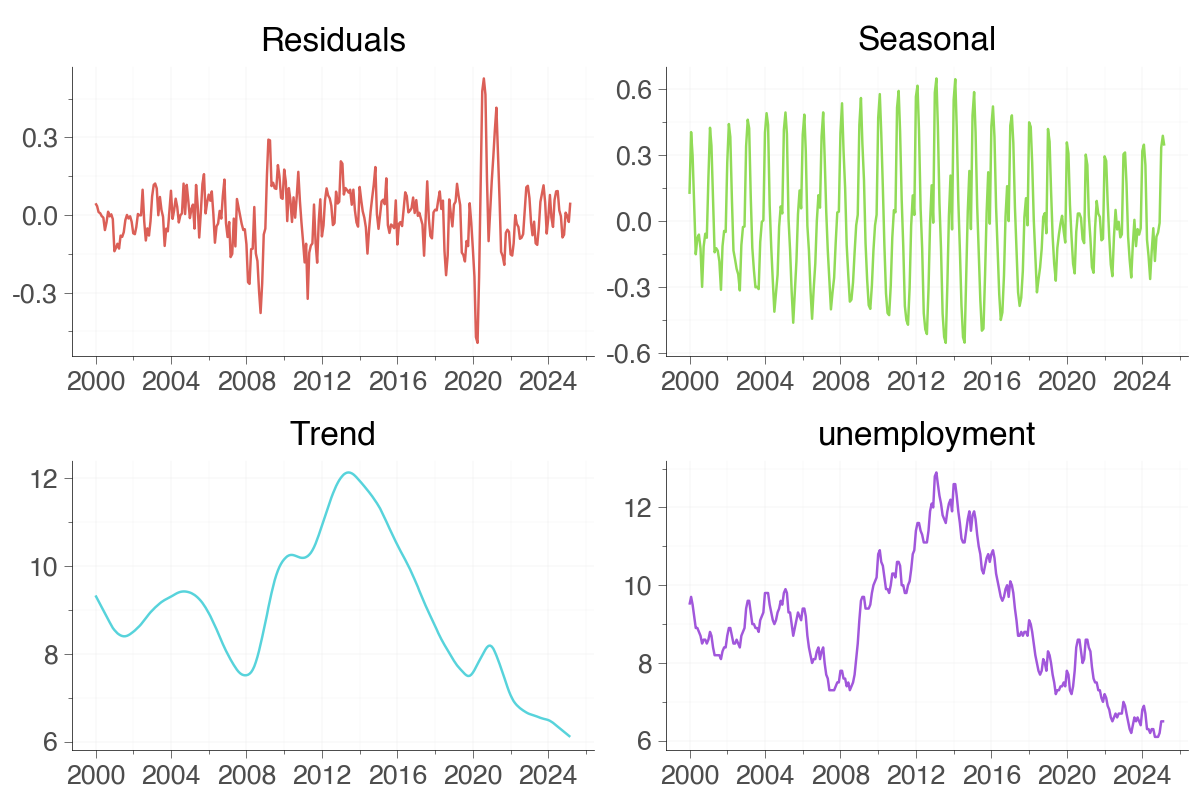

In [20]:
plot_stl = (
    ggplot(data=df_long, mapping=aes(x = 'date', y = 'values',  color = 'variables')) +
    geom_line() +
    facet_wrap(facets='variables', scales='free') +
    theme(figure_size = (6, 4), legend_position='none') +
    labs(x = '', y = '') +
    scale_x_date(breaks='4 years', date_labels='%Y')
)
plot_stl

In [19]:
ggsave(self = plot_stl, filename = '../../Output/plot_stl.png', dpi = 500, verbose=False)

In [21]:
macro2.write_csv('../../Data/macro2.csv')